In [50]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
from tqdm import tqdm
import json
import string
from argparse import ArgumentParser
import pickle

unk = '<UNK>'


In [51]:
class RNN(nn.Module):
    def __init__(self, input_dim, h):
        super(RNN, self).__init__()
        self.h = h
        self.numOfLayer = 1  # We will use 1 layer of RNN
        self.rnn = nn.RNN(input_dim, h, self.numOfLayer, nonlinearity='tanh')  # RNN layer with tanh activation
        self.W = nn.Linear(h, 5)  # Linear layer for 5 classes (adjust as needed)
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax for output layer
        self.loss = nn.NLLLoss()  # Negative log likelihood loss for classification

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, inputs):
        _, hidden = self.rnn(inputs)  # hidden state from RNN
        output = self.W(hidden[-1])  # Linear transformation on the last hidden state (for classification)
        predicted_vector = self.softmax(output)  # Applying softmax to get probability distribution
        return predicted_vector


In [52]:
def load_data(train_data, val_data):
    with open(train_data) as training_f:
        training = json.load(training_f)
    with open(val_data) as valid_f:
        validation = json.load(valid_f)

    tra = []
    val = []
    for elt in training:
        tra.append((elt["text"].split(), int(elt["stars"] - 1)))  # Converting stars to 0-4
    for elt in validation:
        val.append((elt["text"].split(), int(elt["stars"] - 1)))  # Converting stars to 0-4
    return tra, val


In [60]:
parser = ArgumentParser()
parser.add_argument("-hd", "--hidden_dim", type=int, default=50, help="Hidden layer dimension")
parser.add_argument("-e", "--epochs", type=int, default=10, help="Number of epochs to train")
parser.add_argument("--train_data", default=r"/content/training.json", help="Path to training data")
parser.add_argument("--val_data", default=r"/content/validation.json", help="Path to validation data")
parser.add_argument("--test_data", default=r"/content/test.json", help="Path to test data")
parser.add_argument('--do_train', action='store_true')
args = parser.parse_args([])  # Empty list to run in Jupyter/Colab

print("========== Loading data ==========")
train_data, valid_data = load_data(args.train_data, args.val_data)  # Load the training and validation data


========== Loading data ==========


In [61]:
print("========== Loading word embeddings ==========")
word_embedding = pickle.load(open("/content/word_embedding.pkl", 'rb'))  # Load pre-trained word embeddings from pickle


========== Loading word embeddings ==========


In [62]:
print("========== Vectorizing data ==========")
model = RNN(50, args.hidden_dim)  # Create RNN model (input_dim=50, hidden_dim from args)
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Use Adam optimizer


========== Vectorizing data ==========


In [63]:
import matplotlib.pyplot as plt
import string
import random
import torch
from tqdm import tqdm

# Initialize lists to store accuracies and losses
train_accuracies = []
val_accuracies = []
train_losses = []  # List to store training losses

stopping_condition = False
epoch = 0
last_train_accuracy = 0
last_validation_accuracy = 0

while not stopping_condition:
    random.shuffle(train_data)  # Shuffle training data
    model.train()  # Set model to training mode

    print("Training started for epoch {}".format(epoch + 1))
    correct = 0
    total = 0
    minibatch_size = 16
    N = len(train_data)

    loss_total = 0
    loss_count = 0
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()  # Reset gradients for each minibatch
        loss = None

        for example_index in range(minibatch_size):
            input_words, gold_label = train_data[minibatch_index * minibatch_size + example_index]
            input_words = " ".join(input_words)

            # Remove punctuation and split words
            input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()

            # Look up word embeddings for the words in the sentence
            vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i in input_words]

            # Convert to tensor and reshape for RNN input: (seq_len, batch_size, input_dim)
            vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
            output = model(vectors)  # Forward pass

            # Calculate loss
            example_loss = model.compute_Loss(output.view(1, -1), torch.tensor([gold_label]))
            predicted_label = torch.argmax(output)

            correct += int(predicted_label == gold_label)
            total += 1

            if loss is None:
                loss = example_loss
            else:
                loss += example_loss

        loss = loss / minibatch_size
        loss_total += loss.data
        loss_count += 1
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters

    avg_train_loss = loss_total / loss_count  # Average loss for the epoch
    train_losses.append(avg_train_loss.item())  # Store training loss
    print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss.item()}")
    print("Training completed for epoch {}".format(epoch + 1))
    train_accuracy = correct / total
    print("Training accuracy for epoch {}: {}".format(epoch + 1, train_accuracy))
    train_accuracies.append(train_accuracy)  # Store training accuracy

    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    random.shuffle(valid_data)
    print("Validation started for epoch {}".format(epoch + 1))

    for input_words, gold_label in tqdm(valid_data):
        input_words = " ".join(input_words)
        input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()
        vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i in input_words]

        vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
        output = model(vectors)
        predicted_label = torch.argmax(output)
        correct += int(predicted_label == gold_label)
        total += 1

    validation_accuracy = correct / total
    print("Validation completed for epoch {}".format(epoch + 1))
    print("Validation accuracy for epoch {}: {}".format(epoch + 1, validation_accuracy))
    val_accuracies.append(validation_accuracy)  # Store validation accuracy

    # Early stopping check
    if validation_accuracy < last_validation_accuracy and train_accuracy > last_train_accuracy:
        stopping_condition = True
        print("Training done to avoid overfitting!")
        print("Best validation accuracy is:", last_validation_accuracy)
    else:
        last_validation_accuracy = validation_accuracy
        last_train_accuracy = train_accuracy

    epoch += 1

Training started for epoch 1


100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]


Average training loss for epoch 1: 1.6637827157974243
Training completed for epoch 1
Training accuracy for epoch 1: 0.2169375
Validation started for epoch 1


100%|██████████| 800/800 [00:07<00:00, 113.43it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.2125
Training started for epoch 2


100%|██████████| 1000/1000 [04:20<00:00,  3.85it/s]


Average training loss for epoch 2: 1.6515223979949951
Training completed for epoch 2
Training accuracy for epoch 2: 0.21675
Validation started for epoch 2


100%|██████████| 800/800 [00:07<00:00, 109.41it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.0875
Training started for epoch 3


100%|██████████| 1000/1000 [04:22<00:00,  3.80it/s]


Average training loss for epoch 3: 1.642458200454712
Training completed for epoch 3
Training accuracy for epoch 3: 0.231875
Validation started for epoch 3


100%|██████████| 800/800 [00:06<00:00, 120.76it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.32625
Training started for epoch 4


100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]


Average training loss for epoch 4: 1.6305583715438843
Training completed for epoch 4
Training accuracy for epoch 4: 0.2421875
Validation started for epoch 4


100%|██████████| 800/800 [00:06<00:00, 132.49it/s]

Validation completed for epoch 4
Validation accuracy for epoch 4: 0.1075
Training done to avoid overfitting!
Best validation accuracy is: 0.32625


In [64]:
print("Final Training Accuracy:", last_train_accuracy)
print("Final Validation Accuracy:", last_validation_accuracy)

if args.test_data is not None:
    model.eval()  # Set model to evaluation mode
    print("========== Testing on test data ==========")
    test_data, _ = load_data(args.test_data, args.val_data)  # Load test data

    correct = 0
    total = 0

    # Iterate over each test example
    for input_words, gold_label in tqdm(test_data):
        input_words = " ".join(input_words)
        # Remove punctuation and split words
        input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()
        # Get word embeddings for the words in the sentence
        vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i in input_words]

        # Convert to tensor and reshape for RNN input: (seq_len, batch_size, input_dim)
        vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
        output = model(vectors)  # Forward pass to get the model's output
        predicted_label = torch.argmax(output)  # Get the predicted class

        # Count correct predictions
        correct += int(predicted_label == gold_label)
        total += 1

    # Calculate and print test accuracy
    test_accuracy = correct / total
    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


Final Training Accuracy: 0.231875
Final Validation Accuracy: 0.32625
========== Testing on test data ==========


100%|██████████| 800/800 [00:04<00:00, 162.36it/s]

Test Accuracy: 36.12%


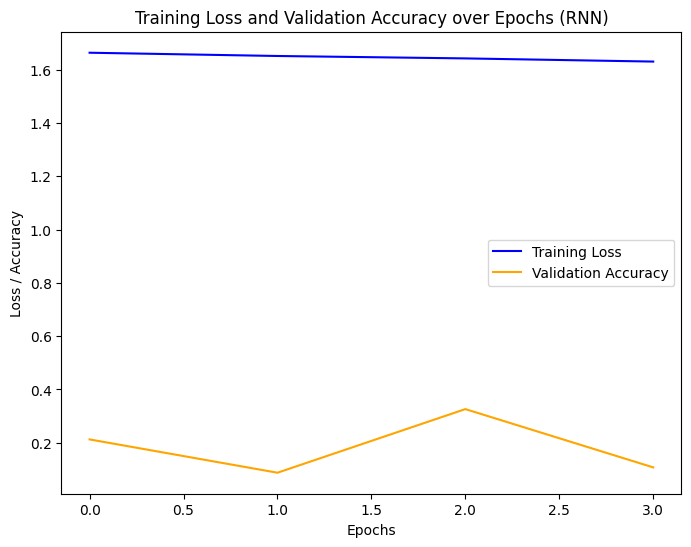

In [65]:
import matplotlib.pyplot as plt

# Check if train_losses and val_accuracies are populated with data
if len(train_losses) == 0 or len(val_accuracies) == 0:
    print("train_losses or val_accuracies are empty. Please check your data.")
else:
    # Define the number of epochs based on the data length
    epochs = len(train_losses)  # assuming train_losses and val_accuracies have the same length

    # Plot training loss and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs), train_losses, label="Training Loss", color="blue")
    plt.plot(range(epochs), val_accuracies, label="Validation Accuracy", color="orange")

    # Adding labels, title, and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    plt.title("Training Loss and Validation Accuracy over Epochs (RNN)")
    plt.legend()

    # Show plot
    plt.show()
